In [2]:
%pip install torch==2.2.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.htmlNote: you may need to restart the kernel to use updated packages.



In [1]:
import torch
torch.__version__

'2.2.2+cu118'

In [3]:
import torch
import torch.nn as nn

# Simple model test
class TestNN(nn.Module):
    def __init__(self):
        super(TestNN, self).__init__()
        self.layer = nn.Linear(2, 1)

    def forward(self, x):
        return self.layer(x)

# Initialize and test
model = TestNN()
x = torch.tensor([[1.0, 2.0]])
output = model(x)

print("Torch is working! Output:", output)


Torch is working! Output: tensor([[-1.7515]], grad_fn=<AddmmBackward0>)


Epoch [10/100], Loss: 68719544.0000
Epoch [20/100], Loss: 66362172.0000
Epoch [30/100], Loss: 36078684.0000
Epoch [40/100], Loss: 161080512.0000
Epoch [50/100], Loss: 79456568.0000
Epoch [60/100], Loss: 174541280.0000
Epoch [70/100], Loss: 76093872.0000
Epoch [80/100], Loss: 103311768.0000
Epoch [90/100], Loss: 153418064.0000
Epoch [100/100], Loss: 93760400.0000


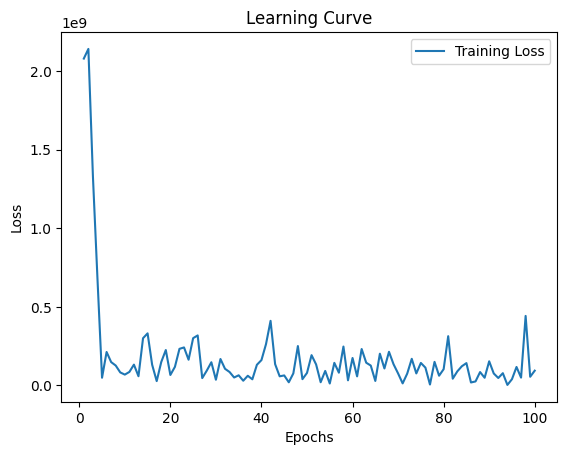

Test MSE: 115325864.0000

Actual vs Predicted Attendance:
   Actual Attendance  Predicted Attendance
0             9022.0          16011.106445
1            10552.0          29805.312500
2            38492.0          35740.214844
3            51892.0          50748.425781
4            52475.0          37649.574219


In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

# Load dataset
mainDF = pd.read_csv(r'C:\Users\raadr\OneDrive\Desktop\AflAnalysis-\data\interim\H&AsesData.csv')
mainDF = mainDF.dropna()

# Define features and target
X = mainDF[['Year', 'Round', 'MaxTemp', 'Rainfall', 'Venue', 'HomeTeam', 'AwayTeam', 'Day', 'MinutesSinceMidnight', 'HomeProbability', 'previous_game_home_position','previous_game_away_position', 'previous_game_home_win_loss', 'previous_game_away_win_loss']]
Y = mainDF['Attendance']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Normalize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Deep Neural Network (DNN)
class AttendanceDNN(nn.Module):
    def __init__(self, input_size):
        super(AttendanceDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),  # First hidden layer with 128 neurons
            nn.ReLU(),
            nn.Linear(128, 64),  # Second hidden layer with 64 neurons
            nn.ReLU(),
            nn.Linear(64, 32),  # Third hidden layer with 32 neurons
            nn.ReLU(),
            nn.Linear(32, 16),  # Fourth hidden layer with 16 neurons
            nn.ReLU(),
            nn.Linear(16, 1)  # Output layer
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
input_size = X_train.shape[1]
model = AttendanceDNN(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Plot learning curve
plt.plot(range(1, num_epochs+1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Evaluate on test data and make predictions
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    
    # Convert tensors to numpy arrays
    test_predictions = test_predictions.numpy().flatten()  # Flatten to make it a 1D array
    y_test_actual = y_test_tensor.numpy().flatten()  # Flatten actual values to compare easily

    # Calculate MSE
    mse = mean_squared_error(y_test_actual, test_predictions)
    print(f"Test MSE: {mse:.4f}")

    # Create a DataFrame with actual and predicted attendance
    results_df = pd.DataFrame({
        'Actual Attendance': y_test_actual,
        'Predicted Attendance': test_predictions
    })

    # Display the DataFrame
    print("\nActual vs Predicted Attendance:")
    print(results_df.head())  # Print the first few rows of the DataFrame for inspection


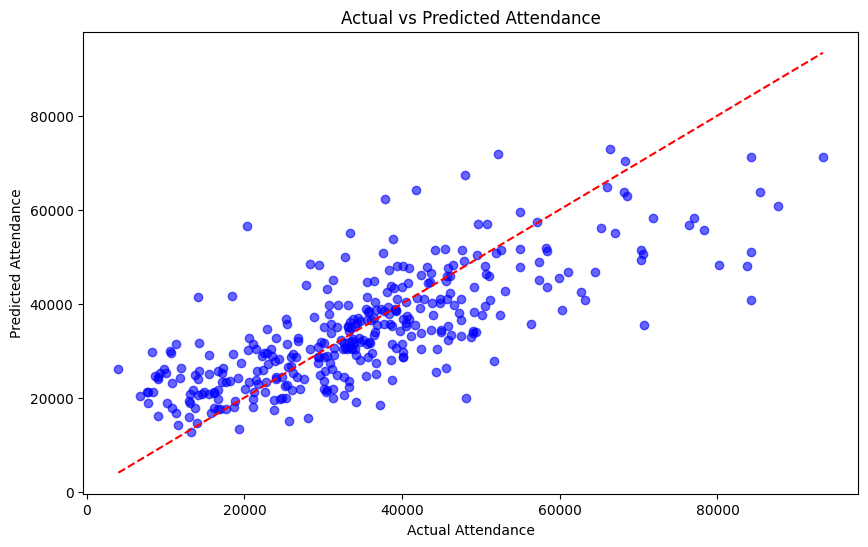

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, test_predictions, color='blue', alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--')
plt.title('Actual vs Predicted Attendance')
plt.xlabel('Actual Attendance')
plt.ylabel('Predicted Attendance')
plt.show()